In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tqdm

# Tải dataset về drive

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("jangedoo/utkface-new")

# print("Path to dataset files:", path)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aibloy/fairface")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fairface' dataset.
Path to dataset files: /kaggle/input/fairface


In [ ]:
# import shutil

# drive_path = "/content/drive/MyDrive/kltn/cv/data/train"
# shutil.copytree(path, drive_path, dirs_exist_ok=True)

# print("Copied to:", drive_path)

# Prepare Dataset

In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class FairFaceDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

        # Fix cột tên file nếu KaggleHub đổi format
        if "file" not in self.df.columns:
            self.df.rename(columns={"img": "file"}, inplace=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.img_dir, row["file"])
        img = Image.open(img_path).convert("RGB")

        # gender: "Male" hoặc "Female"
        gender = row["gender"]

        # Chuyển về label
        label = 0 if gender == "Male" else 1

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
class UTKFaceDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.images = [
        f for f in os.listdir(root_dir)
        if f.endswith('.jpg') or f.endswith('.png')
    ]

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_name = self.images[idx]
    img_path = os.path.join(self.root_dir, img_name)
    gender = int(img_name.split('_')[1]) # 0 = male, 1 = female
    image = Image.open(img_path).convert("RGB")

    if self.transform:
      image = self.transform(image)
    return image, gender

In [ ]:
# dataset_temp = UTKFaceDataset(path + "/UTKFace", transform=None)

In [ ]:
# len(dataset_temp)

In [ ]:
# import matplotlib.pyplot as plt

# img, gender = dataset_temp[100]
# print(gender)
# plt.imshow(img)
# plt.axis('off')
# plt.show()

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# dataset = UTKFaceDataset(path + "/UTKFace", transform=transform)

In [ ]:
# from torch.utils.data import random_split, DataLoader

# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size

# train_ds, val_ds = random_split(dataset, [train_size, val_size])

# train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
# val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_csv = path + "/FairFace/train_labels.csv"
val_csv   = path + "/FairFace/val_labels.csv"
train_dir   = path + "/FairFace"
val_dir     = path + "/FairFace"

train_dataset = FairFaceDataset(train_csv, train_dir, transform)
val_dataset   = FairFaceDataset(val_csv, val_dir, transform)

In [ ]:
print(len(train_dataset))
print(len(val_dataset))

86744
10954


In [ ]:
from torch.utils.data import random_split

val_size = len(val_dataset)           # 10954
test_size = int(0.3 * val_size)       # ~3286
new_val_size = val_size - test_size   # ~7668

val_dataset_new, test_dataset = random_split(
    val_dataset,
    [new_val_size, test_size]
)

print(len(val_dataset_new), len(test_dataset))

7668 3286


Label: 1


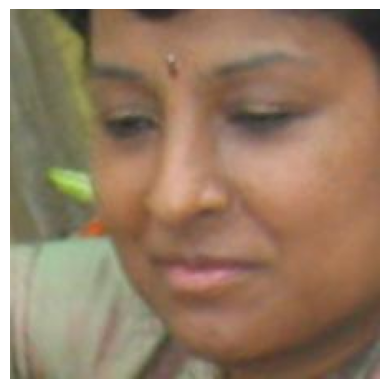

In [ ]:
img, label = train_dataset[1]
print("Label:", label)

img_np = img.permute(1, 2, 0).numpy()
img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
img_np = np.clip(img_np, 0, 1)
plt.imshow(img_np)
plt.axis('off')
plt.show()

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load model

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

In [ ]:
class GenderResNet50(nn.Module):
  def __init__(self, num_classes = 2, pretrained = True):
    super(GenderResNet50, self).__init__()
    #load resnet18 gốc
    self.model = models.resnet50(pretrained = pretrained)
    in_features = self.model.fc.in_features
    self.model.fc = nn.Sequential(
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
# Khởi tạo mô hình
model = GenderResNet50(num_classes=2, pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Optimizer + Loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Training & evaluate

In [ ]:
from tqdm import tqdm

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct = 0, 0

    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for imgs, labels in progress_bar:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

        progress_bar.set_postfix({
            "loss": loss.item()
        })

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_correct / len(dataloader.dataset)

    return avg_loss, avg_acc

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_acc = 0, 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            total_acc += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / len(dataloader.dataset)

    return avg_loss, avg_acc

In [ ]:
epochs = 5
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)
trains_loss = []
vals_loss = []
trains_acc = []
vals_acc = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    trains_loss.append(train_loss)
    vals_loss.append(val_loss)
    trains_acc.append(train_acc)
    vals_acc.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/5


Epoch 1/5 | Train Acc: 0.8778 | Val Acc: 0.9036
Epoch 2/5


Epoch 2/5 | Train Acc: 0.9255 | Val Acc: 0.9132
Epoch 3/5


Epoch 3/5 | Train Acc: 0.9467 | Val Acc: 0.9215
Epoch 4/5


Epoch 4/5 | Train Acc: 0.9632 | Val Acc: 0.9188
Epoch 5/5


Epoch 5/5 | Train Acc: 0.9751 | Val Acc: 0.9220


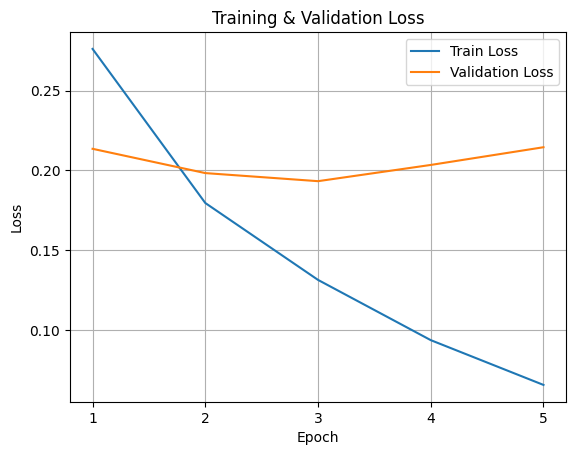

In [ ]:
epochs_range = range(1, epochs + 1)

plt.figure()
plt.plot(epochs_range, trains_loss)
plt.plot(epochs_range, vals_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend(["Train Loss", "Validation Loss"])
plt.grid(True)
plt.xticks(epochs_range)
plt.show()

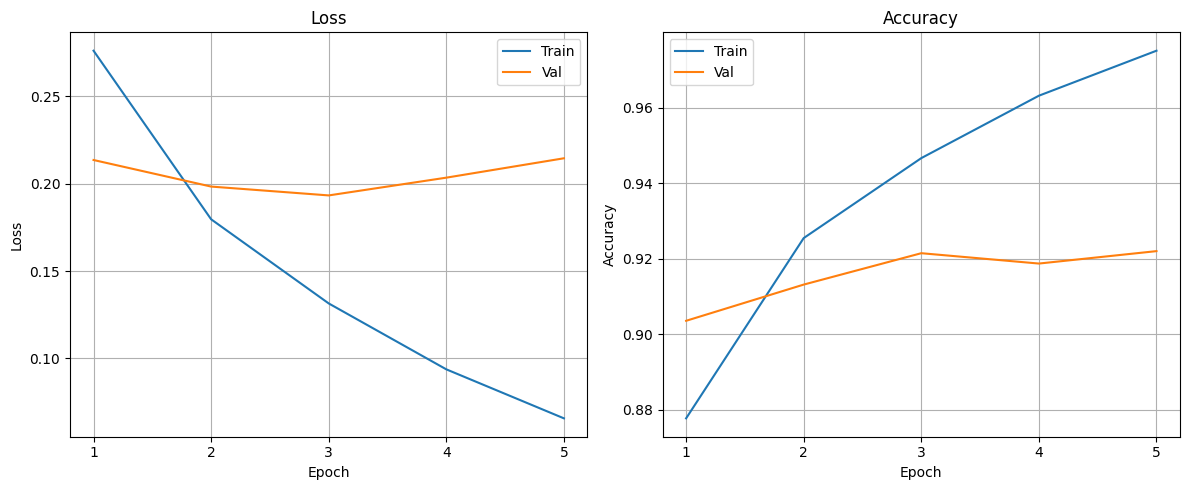

In [ ]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, trains_loss)
plt.plot(epochs_range, vals_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend(["Train", "Val"])
plt.grid(True)
plt.xticks(epochs_range)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, trains_acc)
plt.plot(epochs_range, vals_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend(["Train", "Val"])
plt.grid(True)
plt.xticks(epochs_range)
plt.tight_layout()
plt.show()

In [ ]:
# Lưu model về drive
save_path = "/content/drive/MyDrive/kltn/cv/model/resnet50_gender.pth"
torch.save(model.state_dict(), save_path)
print("Saved to:", save_path)

Saved to: /content/drive/MyDrive/kltn/cv/model/resnet50_gender.pth


# Predict

In [ ]:
model_path = "/content/drive/MyDrive/kltn/cv/model/resnet50_gender.pth"
model = GenderResNet50(num_classes=2, pretrained=True)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

GenderResNet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [ ]:
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print(f"Test Acc: {test_acc:.4f}")

Test Acc: 0.9273


In [ ]:
from sklearn.metrics import classification_report

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(
    y_true,
    y_pred,
    target_names=["Male", "Female"]
))

              precision    recall  f1-score   support

        Male       0.94      0.92      0.93      1726
      Female       0.92      0.93      0.92      1560

    accuracy                           0.93      3286
   macro avg       0.93      0.93      0.93      3286
weighted avg       0.93      0.93      0.93      3286



In [ ]:
print(cm)

[[1594  132]
 [ 107 1453]]


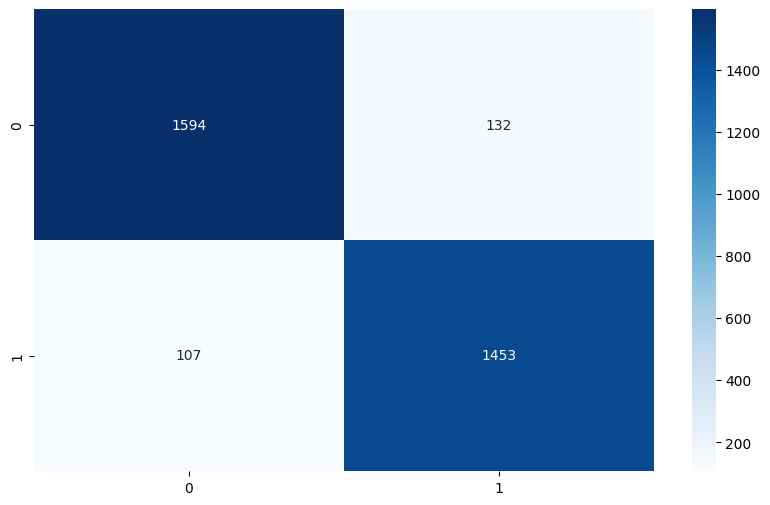

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
def predict_gender(model, image_path, transform, device):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        pred = output.argmax(1).item()

    return "Male" if pred == 0 else "Female"

In [ ]:
path_test = "/content/drive/MyDrive/kltn/cv/data/test/"

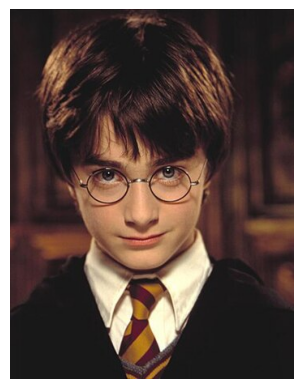

Male


In [ ]:
img = path_test + "harry.jpg"
plt.imshow(Image.open(img))
plt.axis('off')
plt.show()
print(predict_gender(model, img, transform, device))

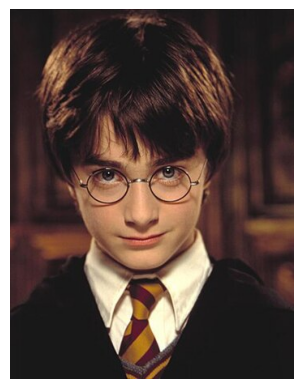

In [ ]:
img_path = path_test + "/harry.jpg"
img = Image.open(img_path).convert("RGB")
plt.imshow(img)
plt.axis('off')
plt.show()

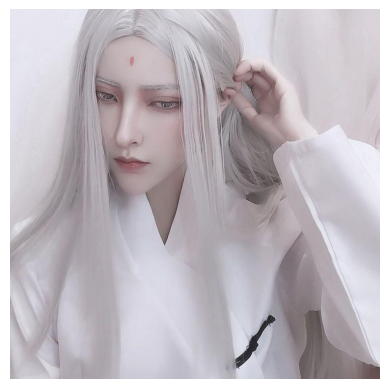

Female


In [ ]:
img = path_test + "/white.jpg"
plt.imshow(Image.open(img))
plt.axis('off')
plt.show()
print(predict_gender(model, img, transform, device))